# Design of the RBF kernel with full precision matrix

In [56]:
import matplotlib.pyplot as plt # 3.6
import numpy as np # 1.22.4
import tensorflow as tf # 2.11.0
import gpflow # 2.7.0
import pandas as pd
import tensorflow_probability as tfp
from tensorflow import keras
import seaborn as sns
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
print('tensorflow ', tf.__version__) 
print('numpy ', np.__version__) 
print('gpflow ', gpflow.__version__) 
print('pandas ', pd.__version__) 

tensorflow  2.11.0
numpy  1.22.4
gpflow  2.7.0
pandas  1.5.3


## Dataset: Boston - Regression problem

In [3]:
plt.rcParams["figure.figsize"] = (12, 6)
plt.style.use("ggplot")
(X_train, Y_train), (X_test, Y_test) = keras.datasets.boston_housing.load_data()
Y_train = np.atleast_2d(Y_train).T
Y_test = np.atleast_2d(Y_test).T
Y_train_mean, Y_train_std = Y_train.mean(0), Y_train.std(0) + 1e-9
Y_train = (Y_train - Y_train_mean) / Y_train_std
Y_test = (Y_test - Y_train_mean) / Y_train_std

We are now working with a 2D version of this dataset (only 2 features) in order to be able to visualize it

In [4]:
X_train_2D = X_train[:,4:6].astype('float64')
X_test_2D = X_test[:,4:6].astype('float64')

2023-03-22 14:52:23.479994: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


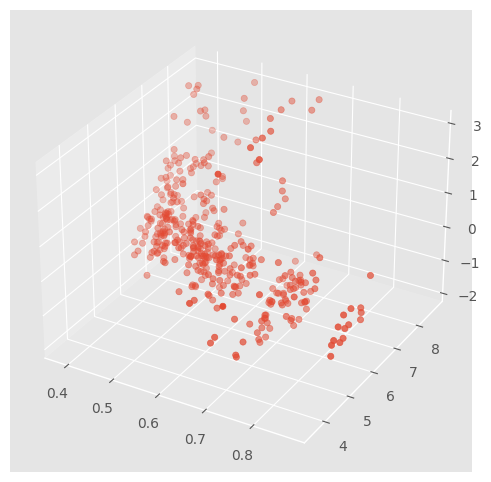

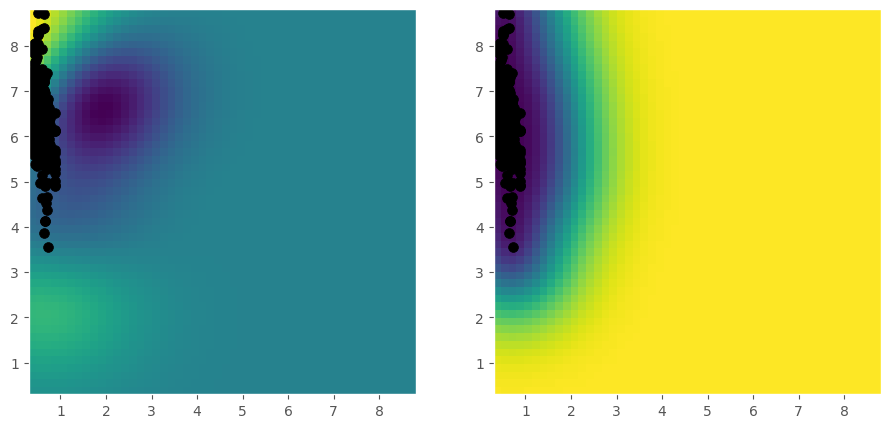

In [5]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(X_train_2D[:,0], X_train_2D[:,1], Y_train)
def plot_2d_model(model, X, Y):
    n_grid = 50
    _, (ax_mean, ax_std) = plt.subplots(nrows=1, ncols=2, figsize=(11, 5))
    Xplots = np.linspace(np.min(X), np.max(X), n_grid)
    Xplot1, Xplot2 = np.meshgrid(Xplots, Xplots)
    Xplot = np.stack([Xplot1, Xplot2], axis=-1)
    Xplot = Xplot.reshape([n_grid ** 2, 2])

    opt = gpflow.optimizers.Scipy()
    opt.minimize(model.training_loss, model.trainable_variables)

    y_mean, y_var = model.predict_y(Xplot)
    y_mean = y_mean.numpy()
    y_std = tf.sqrt(y_var).numpy()

    ax_mean.pcolor(Xplot1, Xplot2, y_mean.reshape(Xplot1.shape))
    ax_std.pcolor(Xplot1, Xplot2, y_std.reshape(Xplot1.shape))
    ax_mean.scatter(X[:, 0], X[:, 1], s=50, c="black")
    ax_std.scatter(X[:, 0], X[:, 1], s=50, c="black")


model = gpflow.models.GPR(
    (X_train_2D, Y_train),
    kernel=gpflow.kernels.RBF(),
)
plot_2d_model(model, X_train_2D, Y_train)

In [57]:
def visualize_matrix(matrix, cmap='viridis'):
    """
    matrix: Matrix to be visualized with a color mapping
    cmap: type of mapping
    ---
    It displays a matrix represented with a color scheme
    """
    D = matrix.shape[0]
    #plt.imshow(matrix, cmap=cmap, extent=[0, D, 0, D], interpolation='nearest')
    #plt.xticks(np.arange(D) + 0.5, np.arange(D))
    #plt.yticks(np.arange(D) + 0.5, np.arange(D))
    #plt.colorbar()
    #plt.show()
    min = np.min(matrix)
    max = np.max(matrix)
    center = (min+max)/2
    sns.heatmap(matrix, annot=True, cmap='vlag', vmax=max, vmin=min, center=center, linewidth=.5)


We are going to extend the Automatic Relevance Determination techique tipically used togheter with stationary kernels like Squared Exponential (RBF).

We are working on the prior probabability $p(\textbf{f}|\Theta)$. The prior knowledge is expressed by the precomputed Kernel matrix $K_{xx|\Theta}$ where $K_{xx|\Theta}[i,j] = k(x_i,x_j|\Theta)$. \\
The RBF kernel function $k$ is defined as:
$$k(x_i,x_j|\sigma_f^2,\Lambda) = \sigma_f^2e^{-\frac{1}{2}(x_i-x_j)^T\Lambda(x_i-x_j)}$$
where $\Lambda$ is the precision matrix of the kernel.

In ARD the precision matrix of the kernel is of the form:
$$diag([\alpha_0,\alpha_1,...,\alpha_{D-1}])$$ 
where $D$ is the number of features. The values on the diagonal are called lengthscales because they represent a form of scaling of the squared norm that is computed among couples of feature vectors. 

What we are willing to do is extending the ARD mechanism to a more general one where we can optimize for the entire precision matrix $\Lambda$ instead of only the diagonal (explain here the link between a zero in the precision matrix and conditional independence). For this purpose we are going to design a modified version of the RBF kernel in which the trainable hyperparameters are $\sigma_f^2$ and the full matrix $\Lambda$

### How RBF with ARD is implemented in GPFlow 

$$k(x_i,x_j|\sigma_f^2,\Lambda) = \sigma_f^2e^{||\frac{X-X2^T}{\textbf{l}}||^2}$$
where $\textbf{l}$ is a $D$-dimensional array containing the lengthscales of each dimension $[\lambda_0,\lambda_1,...,\lambda_D]$. If we suppose $D=2$ we can express the scaled norm between two samples as:
$$||\frac{x_i-x_j}{\textbf{l}}||^2 = (x_i-x_j)^T\begin{bmatrix} l_0 & 0 \\ 0 & l_1 \end{bmatrix}^{-1}(x_i-x_j) = (x_i-x_j)^T\begin{bmatrix} \lambda_0 & 0 \\ 0 & \lambda_1 \end{bmatrix}(x_i-x_j)$$

$$\lambda_i = \frac{1}{l_i^2}$$
$$l_i = \sqrt{\frac{1}{\lambda_i}}$$

### Full Lambda matrix RBF kernel

We need to work with $\Lambda$ that is positive definite so during the optimization algorithm $\Lambda$ is not allow to take all possible values. We prefer to directly work with the Cholesky decomposition of the matrix that is:
$$\Lambda = LL^T$$ 
where $L$ is a lower-triangular matrix.

We also need to be able to compute the RBF in matrix form in order to avoid loops and speed up the computation:

$$(x_i-x_j)^T\Lambda(x_i-x_j) = x_i^T\Lambda x_i - 2x_i^T\Lambda x_j + x_j^T\Lambda x_j \in [N,N]$$

so each component of this equation is a $[N,N]$ matrix. We start computing the first component:

$$z = \sum_{rows}{(X\Lambda)\odot X}$$

1. $X\Lambda = $

In [46]:
class LambdaRBF(gpflow.kernels.Kernel):  
    def __init__(self, Lambda_L, variance=1.0):
        super().__init__()
        # Create a Parameter associated to Lambda matrix
        # self.Lambda_L = gpflow.Parameter(Lambda_L, transform=gpflow.utilities.triangular(), dtype=tf.float64, name='KernelPrecision_L') OK
        self.Lambda_L = gpflow.Parameter(Lambda_L, transform=None, dtype=tf.float64, name='KernelPrecision_L')
        self.variance = gpflow.Parameter(variance, transform=gpflow.utilities.positive(), dtype=tf.float64, name='KernelAmplitude')
        #self.Kxx = tf.Variable(np.empty((N, N), dtype=np.float64), name='KernelMatrix')

    def K(self, X, X2=None):
        """
            X: matrix NxD
            X2: matrix NxD
            ---
            Returns Kernel matrix as a 2D tensor
        """
        if X2 is None:
            X2 = X
        N1 = X.shape[0]
        N2 = X2.shape[0]
        Lambda = tfp.math.fill_triangular(self.Lambda_L) # TRY
        Lambda = tf.linalg.matmul(Lambda, tf.transpose(Lambda))
        # Lambda = tf.linalg.matmul(self.Lambda_L, tf.transpose(self.Lambda_L)) # recover LLᵀ

        # compute z, z2
        z = self._z(X, Lambda) # N1x1 array
        z2 = self._z(X2, Lambda) # N2x1 array
        # compute X(X2Λ)ᵀ
        X2Lambda = tf.linalg.matmul(X2, Lambda)
        XX2LambdaT = tf.linalg.matmul(X, tf.transpose(X2Lambda)) # N1xN2 matrix
        # compute z1ᵀ 
        ones_N2 = tf.ones(shape=(N2,1), dtype=tf.float64) # N2x1 array
        zcol = tf.linalg.matmul(z, tf.transpose(ones_N2)) # N1xN2 matrix
        # compute 1z2ᵀ 
        ones_N1 = tf.ones(shape=(N1,1), dtype=tf.float64) # N1x1 array
        zrow = tf.linalg.matmul(ones_N1, tf.transpose(z2)) # N1xN2 matrix

        exp_arg = zcol - 2*XX2LambdaT + zrow
        Kxx = tf.math.exp(-0.5 * exp_arg)
        return self.variance * Kxx
    
    def K_diag(self, X):
        N = X.shape[0]
        return tf.fill([N,], self.variance)  # this returns a 1D tensor
        #return tf.linalg.diag_part(self.K(X))
    
    def _z(self, X, Lambda):
        XLambda = tf.linalg.matmul(X, Lambda)
        XLambdaX = tf.math.multiply(XLambda, X)
        return tf.math.reduce_sum(XLambdaX, axis=1, keepdims=True)
    
    def _to_array(self, L):
        D = tf.shape(L).numpy()[0]
        return tf.reshape(L, [D*2,1])
    
    def _to_matrix(self, l):
        D = int(tf.shape(l).numpy()[0]/2)
        return tf.reshape(l, [D,D])

In [44]:
def get_lower_triangular_diag(diag):
    Lambda_inv = tf.linalg.diag(diag)
    Lambda = tf.linalg.inv(Lambda_inv)
    L = tf.linalg.cholesky(Lambda)
    return L

lengthscales = tf.constant([2**0.5]*2, dtype=tf.float64)
Lambda_L = get_lower_triangular_diag(lengthscales)
tfp.math.fill_triangular_inverse(Lambda_L)

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([0.84089642, 0.        , 0.84089642])>

In [47]:
#Lambda = tf.constant([[1/4, 0],[0, 1/4]], dtype=tf.float64)#(1/4)*tf.eye(2, dtype=tf.float64)
D = 2
triangular_size = gpflow.utilities.bijectors.triangular_size(D)
#l = tf.ones([triangular_size], dtype=tf.float64)
lengthscales = tf.constant([D**0.5]*D, dtype=tf.float64)
Lambda_L = get_lower_triangular_diag(lengthscales)
Lambda_L = tfp.math.fill_triangular_inverse(Lambda_L) # TRY
LSE = LambdaRBF(Lambda_L, 1.0)
Kxx = LSE.K(X_train_2D[0:10,:])
Kxx[3,6]

<tf.Tensor: shape=(), dtype=float64, numpy=0.9040753056173652>

In [48]:
k = gpflow.kernels.SquaredExponential(variance=1, lengthscales=[D**0.5]*D)
Kxx = k.K(X_train_2D[0:10,:])
Kxx[3,6]

<tf.Tensor: shape=(), dtype=float64, numpy=0.9311764428049997>

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.Lambda_L,Parameter,Identity,,True,"(3,)",float64,[0.8409 0. 0.8409]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


Intial value of kernel variance:  <Parameter: name=KernelAmplitude, dtype=float64, shape=[], fn="softplus", numpy=1.0>
Initial value of Lambda:  tf.Tensor(
[[0.70710678 0.        ]
 [0.         0.70710678]], shape=(2, 2), dtype=float64)
Initial LML:  tf.Tensor(-18.299118144773793, shape=(), dtype=float64)
-------------------------------
Optimal value of kernel variance:  <Parameter: name=KernelAmplitude, dtype=float64, shape=[], fn="softplus", numpy=0.19255225215281704>
Initial value of Lambda:  tf.Tensor(
[[11.40128422  9.71325265]
 [ 9.71325265  8.27514473]], shape=(2, 2), dtype=float64)
Final LML:  tf.Tensor(-17.09811112316298, shape=(), dtype=float64)


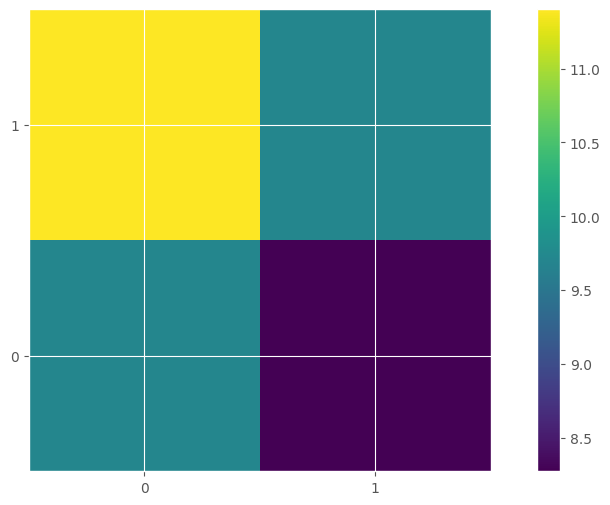

In [49]:
#Lambda = tf.constant([[1/4, 0],[0, 1/4]], dtype=tf.float64)#(1/4)*tf.eye(2, dtype=tf.float64)
D = 2
triangular_size = gpflow.utilities.bijectors.triangular_size(D)
lengthscales = tf.constant([D**0.5]*D, dtype=tf.float64)
Lambda_L = get_lower_triangular_diag(lengthscales)
Lambda_L = tfp.math.fill_triangular_inverse(Lambda_L) # TRY
LSE = LambdaRBF(Lambda_L, 1.0)
model = gpflow.models.GPR(
    (X_train_2D[0:10,:], Y_train[0:10]),
    kernel=LSE,
)
gpflow.utilities.print_summary(model, fmt="notebook")
print('Intial value of kernel variance: ', LSE.variance)
Lambda_L_matrix = tfp.math.fill_triangular(LSE.Lambda_L)
print('Initial value of Lambda: ', tf.linalg.matmul(Lambda_L_matrix, tf.transpose(Lambda_L_matrix)))
print('Initial LML: ',model.log_marginal_likelihood())
opt = gpflow.optimizers.Scipy()
opt.minimize(model.training_loss, model.trainable_variables)
print('-------------------------------')
print('Optimal value of kernel variance: ', LSE.variance)
Lambda_L_matrix = tfp.math.fill_triangular(LSE.Lambda_L)
print('Initial value of Lambda: ', tf.linalg.matmul(Lambda_L_matrix, tf.transpose(Lambda_L_matrix)))
print('Final LML: ',model.log_marginal_likelihood())
visualize_matrix(tf.linalg.matmul(Lambda_L_matrix, tf.transpose(Lambda_L_matrix)))

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(2,)",float64,[1.41421 1.41421]
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


Intial value of kernel variance:  <Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=1.0>
Intial value of kernel lengthsclaes:  tf.Tensor(
[[0.5 0. ]
 [0.  0.5]], shape=(2, 2), dtype=float64)
Initial LML:  tf.Tensor(-18.58773101443065, shape=(), dtype=float64)
-------------------------------
Optimal value of kernel variance:  <Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=0.11617371132196762>
Optimal value of kernel lengthsclaes:  tf.Tensor(
[[7.05668881e-05 0.00000000e+00]
 [0.00000000e+00 1.48044137e+01]], shape=(2, 2), dtype=float64)
Final LML:  tf.Tensor(-17.131601387198693, shape=(), dtype=float64)


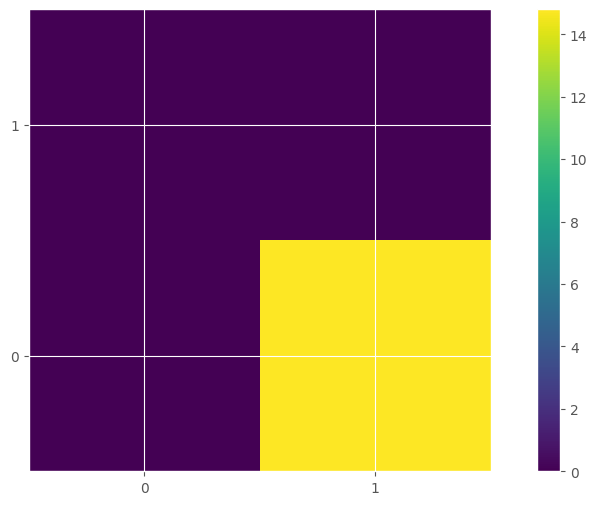

In [50]:
k = gpflow.kernels.SquaredExponential(variance=1, lengthscales=[D**0.5]*D)
model = gpflow.models.GPR(
    (X_train_2D[0:10,:], Y_train[0:10]),
    kernel=k,
)
gpflow.utilities.print_summary(model, fmt="notebook")
print('Intial value of kernel variance: ', k.variance)
print('Intial value of kernel lengthsclaes: ', tf.linalg.diag(1/(k.lengthscales**2)))
print('Initial LML: ',model.log_marginal_likelihood())
opt = gpflow.optimizers.Scipy()
opt.minimize(model.training_loss, model.trainable_variables)
print('-------------------------------')
print('Optimal value of kernel variance: ', k.variance)
print('Optimal value of kernel lengthsclaes: ', tf.linalg.diag(1/(k.lengthscales**2)))
print('Final LML: ',model.log_marginal_likelihood())
visualize_matrix(tf.linalg.diag(1/(k.lengthscales**2)))

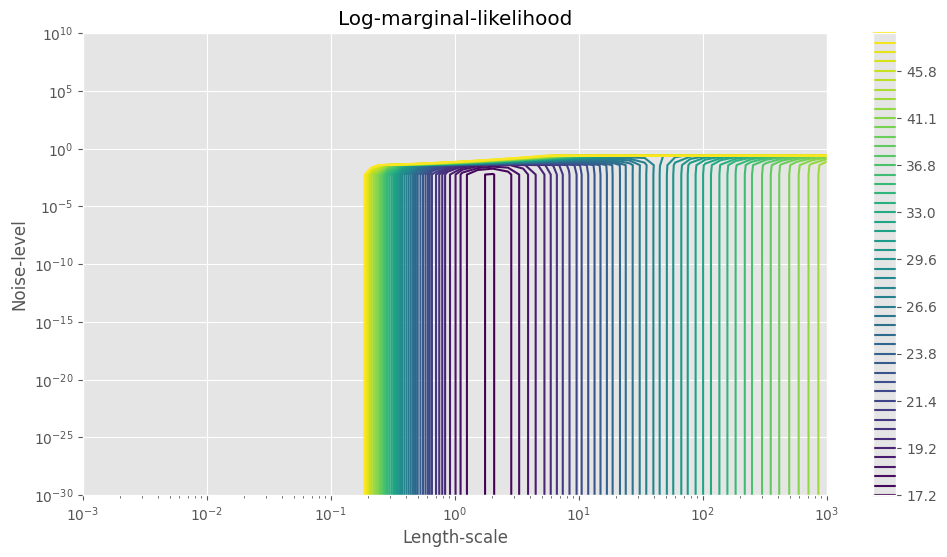

In [13]:
from matplotlib.colors import LogNorm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

kernel = 1.0 * RBF(length_scale=0.1)
gpr = GaussianProcessRegressor(kernel=kernel, alpha=0.0)
gpr.fit(X_train_2D[0:10,:], Y_train[0:10])
#----
length_scale = np.logspace(-3, 3, num=50)
noise_level = np.logspace(-30, 10, num=50)
length_scale_grid, noise_level_grid = np.meshgrid(length_scale, noise_level)

log_marginal_likelihood = []
for scale, noise in zip(length_scale_grid.ravel(), noise_level_grid.ravel()):
    log_marginal_likelihood.append(gpr.log_marginal_likelihood(theta=np.log([scale, noise])))

log_marginal_likelihood = np.reshape(
    log_marginal_likelihood, newshape=noise_level_grid.shape
)
vmin, vmax = (-log_marginal_likelihood).min(), 50
level = np.around(np.logspace(np.log10(vmin), np.log10(vmax), num=50), decimals=1)
plt.contour(
    length_scale_grid,
    noise_level_grid,
    -log_marginal_likelihood,
    levels=level,
    norm=LogNorm(vmin=vmin, vmax=vmax),
)
plt.colorbar()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Length-scale")
plt.ylabel("Noise-level")
plt.title("Log-marginal-likelihood")
plt.show()

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.Lambda_L,Parameter,Identity,Normal,True,"(91,)",float64,"[0.52664, 0., 0...."
GPR.kernel.variance,Parameter,Softplus,Normal,True,(),float64,1.0
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


Intial value of kernel variance:  <Parameter: name=KernelAmplitude, dtype=float64, shape=[], fn="softplus", numpy=1.0>
Initial value of Lambda:  tf.Tensor(
[[0.2773501 0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.       ]
 [0.        0.2773501 0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.       ]
 [0.        0.        0.2773501 0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.       ]
 [0.        0.        0.        0.2773501 0.        0.        0.
  0.        0.        0.        0.        0.        0.       ]
 [0.        0.        0.        0.        0.2773501 0.        0.
  0.        0.        0.        0.        0.        0.       ]
 [0.        0.        0.        0.        0.        0.2773501 0.
  0.        0.        0.        0.        0.        0.       ]
 [0.        0.        0.        0.        0.        0.        0.2773501
  0.

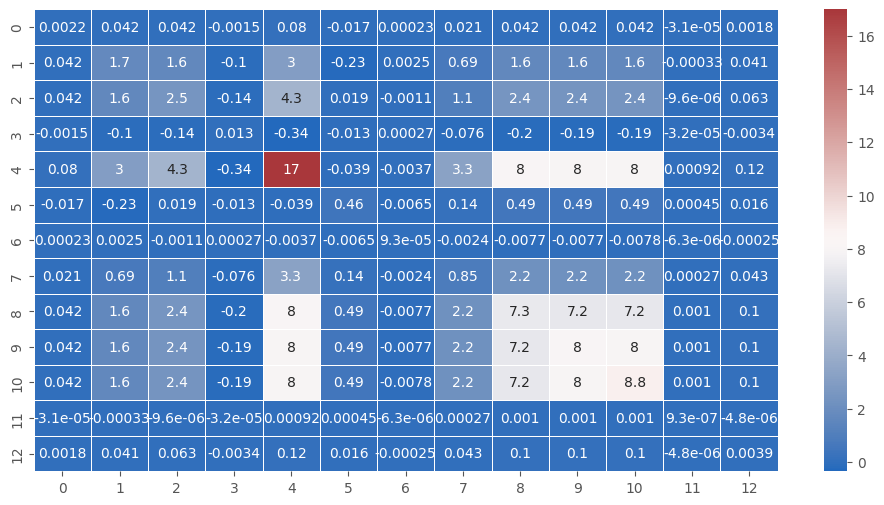

In [59]:
#Lambda = tf.constant([[1/4, 0],[0, 1/4]], dtype=tf.float64)#(1/4)*tf.eye(2, dtype=tf.float64)
D = 13
triangular_size = gpflow.utilities.bijectors.triangular_size(D)
lengthscales = tf.constant([D**0.5]*D, dtype=tf.float64)
Lambda_L = get_lower_triangular_diag(lengthscales)
Lambda_L = tfp.math.fill_triangular_inverse(Lambda_L) # TRY
LSE = LambdaRBF(Lambda_L, 1.0)
LSE.Lambda_L.prior = tfp.distributions.Normal(loc=gpflow.utilities.to_default_float(1.), scale=gpflow.utilities.to_default_float(1.))
LSE.variance.prior = tfp.distributions.Normal(loc=gpflow.utilities.to_default_float(0.05), scale=gpflow.utilities.to_default_float(1.))
model = gpflow.models.GPR(
    (X_train, Y_train),
    kernel=LSE,
)
gpflow.utilities.print_summary(model, fmt="notebook")
print('Intial value of kernel variance: ', LSE.variance)
Lambda_L_matrix = tfp.math.fill_triangular(LSE.Lambda_L)
print('Initial value of Lambda: ', tf.linalg.matmul(Lambda_L_matrix, tf.transpose(Lambda_L_matrix)))
print('Initial LML: ',model.log_marginal_likelihood())
opt = gpflow.optimizers.Scipy()
opt.minimize(model.training_loss, model.trainable_variables)
print('-------------------------------')
print('Optimal value of kernel variance: ', LSE.variance)
Lambda_L_matrix = tfp.math.fill_triangular(LSE.Lambda_L)
print('Initial value of Lambda: ', tf.linalg.matmul(Lambda_L_matrix, tf.transpose(Lambda_L_matrix)))
print('Final LML: ',model.log_marginal_likelihood())
visualize_matrix(tf.linalg.matmul(Lambda_L_matrix, tf.transpose(Lambda_L_matrix)))

In [64]:
L = tf.linalg.cholesky(tf.linalg.matmul(Lambda_L_matrix, tf.transpose(Lambda_L_matrix)))
tf.linalg.diag_part(L)

<tf.Tensor: shape=(13,), dtype=float64, numpy=
array([4.71860001e-02, 9.47432114e-01, 9.41642571e-01, 6.74724390e-02,
       2.64498676e+00, 5.02567806e-01, 1.03412956e-03, 8.49032068e-02,
       9.43439051e-01, 9.42530805e-01, 9.37038738e-01, 7.33259980e-07,
       1.06544869e-04])>

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,Normal,True,(),float64,1.0
GPR.kernel.lengthscales,Parameter,Softplus,Normal,True,"(13,)",float64,"[3.60555, 3.60555, 3.60555..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


Intial value of kernel variance:  <Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=1.0>
Intial value of kernel lengthsclaes:  <Parameter: name=softplus, dtype=float64, shape=[13], fn="softplus", numpy=
array([3.60555128, 3.60555128, 3.60555128, 3.60555128, 3.60555128,
       3.60555128, 3.60555128, 3.60555128, 3.60555128, 3.60555128,
       3.60555128, 3.60555128, 3.60555128])>
Initial LML:  tf.Tensor(-596.9581932967583, shape=(), dtype=float64)
-------------------------------
Optimal value of kernel variance:  <Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=0.7690938309513308>
Optimal value of kernel lengthsclaes:  <Parameter: name=softplus, dtype=float64, shape=[13], fn="softplus", numpy=
array([3.84702933, 1.00032045, 1.00033834, 2.04538162, 0.31640921,
       1.94130894, 6.37579123, 2.23841261, 1.00070111, 0.99877259,
       1.00036933, 6.45505217, 5.09841146])>
Final LML:  tf.Tensor(-483.3437548093102, shape=(), dtype=float64)


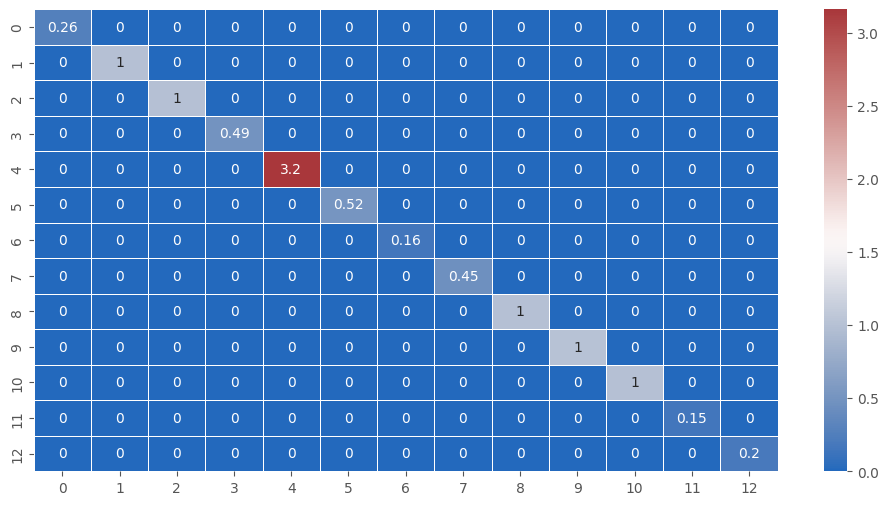

In [58]:
k = gpflow.kernels.SquaredExponential(variance=1, lengthscales=(D**0.5)*np.ones(D))
k.lengthscales.prior = tfp.distributions.Normal(loc=gpflow.utilities.to_default_float(1.), 
                                                   scale=gpflow.utilities.to_default_float(1.))
k.variance.prior = tfp.distributions.Normal(loc=gpflow.utilities.to_default_float(0.05), 
                                               scale=gpflow.utilities.to_default_float(1.))
model_RBF = gpflow.models.GPR(
    (X_train, Y_train),
    kernel=k,
)
gpflow.utilities.print_summary(model_RBF, fmt="notebook")
print('Intial value of kernel variance: ', k.variance)
print('Intial value of kernel lengthsclaes: ', k.lengthscales)
print('Initial LML: ',model_RBF.log_marginal_likelihood())
opt = gpflow.optimizers.Scipy()
opt.minimize(model_RBF.training_loss, model_RBF.trainable_variables)
Lambda_diag = tf.linalg.inv(tf.linalg.diag(k.lengthscales))
print('-------------------------------')
print('Optimal value of kernel variance: ', k.variance)
print('Optimal value of kernel lengthsclaes: ', k.lengthscales)
print('Final LML: ', model_RBF.log_marginal_likelihood())
visualize_matrix(Lambda_diag)